In [75]:
import os, sys, pickle
if '..' not in sys.path:
     sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist, squareform
from IPython.display import display, clear_output

import utils_txt as tut

In [69]:
RESP = (100,220)
ONSET = 50
RESP = slice(ONSET + RESP[0], ONSET + RESP[1])
RAND = 0

CAT = 'face'
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, (f'{CAT}_roi_data.pkl')))
print(f'Unique {CAT} ROIs: {list(dat['roi'].unique())}')

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [22]:
def time_avg_rdm(dat, roi, window=RESP, metric='correlation', random_state=RAND):
    rng = np.random.default_rng(random_state)

    sig = dat[dat['p_value'] < 0.05]
    df = sig[sig['roi'] == roi]
    if len(df) == 0:
        raise ValueError(f"No data for ROI {ROI}")
    X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

    # average unit responses over time window
    Xw = np.nanmean(X[:, window, 1000:], axis=1)
    Xrdv = pdist(Xw.T, metric=metric)
    R = squareform(Xrdv)

    return R, Xrdv

((72, 72), (2556,))

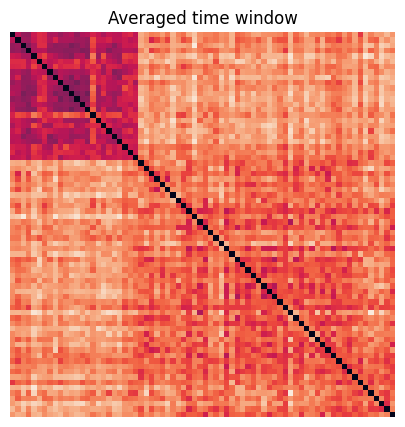

In [93]:
ROI = "Unknown_19_F"
start=130
WIN = (start, start+120)

R, _ = time_avg_rdm(dat, roi=ROI, window=WIN)

fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(R, ax=ax, square=True, cbar=False)
ax.set_title('Averaged time window')
ax.set_axis_off()

plt.show()

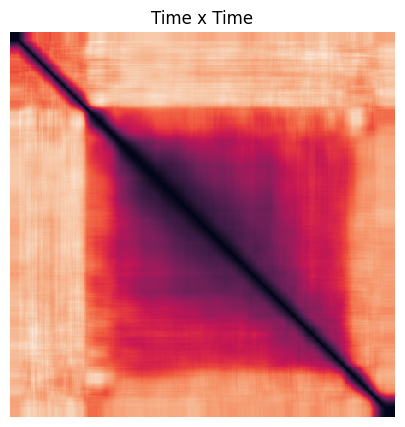

In [106]:
ROI = "MF1_8_F"
WIN = (150, 270)
metric='correlation'
start, stop = 0, 450

sig = dat[dat['p_value'] < 0.05]
df = sig[sig['roi'] == ROI]
if len(df) == 0:
    raise ValueError(f"No data for ROI {ROI}")
X = np.stack(df['img_psth'].to_numpy())          # (units, time, images)

# restrict to desired time window
Ximg = X[:, start:stop, 1000:]                    # (units, time, images)

# time-by-RDV (one RDV per timepoint)
Xrdv = np.array([
    pdist(Ximg[:, t, :].T, metric='correlation')
    for t in range(Ximg.shape[1])
])  # (time, n_pairs)

# # Spearman: rank-transform rows, then use correlation distance across time
Xrank = np.apply_along_axis(rankdata, 1, Xrdv)
R = squareform(pdist(Xrank, metric=metric))      # (time, time)

fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(R, ax=ax, square=True, cbar=False)
ax.set_title('Time x Time')
ax.set_axis_off()

plt.show()

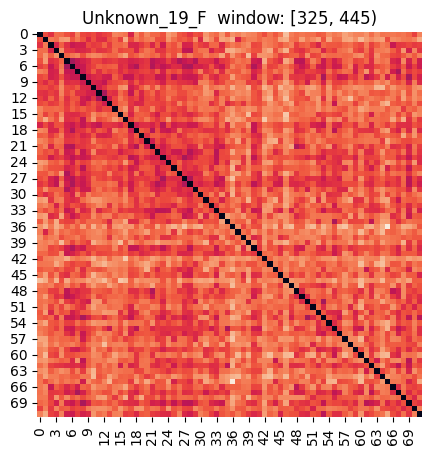

In [82]:
ROI = "Unknown_19_F"

# window params
start, stop = 0, 450
window_len = 120
step = 5

windows = [(t, t + window_len) for t in range(start, stop - window_len, step)]

# one figure, redraw onto same axes
fig, ax = plt.subplots(figsize=(6, 5))

for t0, t1 in windows:
    R, Xrdv = time_avg_rdm(dat, roi=ROI, window=(t0, t1))

    ax.clear()
    sns.heatmap(R, ax=ax, square=True, cbar=False)

    ax.set_title(f"{ROI}  window: [{t0}, {t1})")
    ax.set_xlabel("")
    ax.set_ylabel("")

    clear_output(wait=True)
    display(fig)
    plt.pause(0.1)  # controls how long each frame is shown

plt.close(fig)